In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

In [2]:
# Paths
BASE_DIR = "/kaggle/input/fetal-brain-abnormalities"
DATA_DIR = os.path.join(BASE_DIR, "train")
CSV_PATH = os.path.join(DATA_DIR, "_classes.csv")
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
NUM_WORKERS = 2
MODEL_SAVE_PATH = "cbam_model.pth"

In [3]:

# Load Dataset
def load_dataset_from_folder(folder_path):
    df = pd.read_csv(os.path.join(folder_path, "_classes.csv"))
    image_paths = df['filename'].apply(lambda x: os.path.join(folder_path, x))
    labels = df.drop(columns=['filename']).values
    label_indices = np.argmax(labels, axis=1)
    return image_paths, label_indices

train_paths, train_labels = load_dataset_from_folder(os.path.join(BASE_DIR, "train"))
val_paths, val_labels = load_dataset_from_folder(os.path.join(BASE_DIR, "valid"))
test_paths, test_labels = load_dataset_from_folder(os.path.join(BASE_DIR, "test"))

class_names = pd.read_csv(os.path.join(BASE_DIR, "train", "_classes.csv")).columns[1:].tolist()
num_classes = len(class_names)

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [6]:
# Dataset class
class FetalBrainDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = list(image_paths)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Data Loaders
train_dataset = FetalBrainDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FetalBrainDataset(val_paths, val_labels, transform=val_transform)
test_dataset = FetalBrainDataset(test_paths, test_labels, transform=val_transform)

In [7]:
class_sample_counts = np.bincount(train_labels)
weights = 1. / class_sample_counts
sample_weights = weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))


In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [9]:
# CBAM modules
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

In [ ]:
# ResNet50 + CBAM
class ResNet50_CBAM(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50_CBAM, self).__init__()
        base_model = models.resnet50(pretrained=True)

        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool

        self.layer1 = nn.Sequential(base_model.layer1, CBAM(256))
        self.layer2 = nn.Sequential(base_model.layer2, CBAM(512))
        self.layer3 = nn.Sequential(base_model.layer3, CBAM(1024))
        self.layer4 = nn.Sequential(base_model.layer4, CBAM(2048))

        self.avgpool = base_model.avgpool
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [11]:

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50_CBAM(num_classes=num_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_correct += torch.sum(preds == labels).item()
                val_total += labels.size(0)

        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_correct / val_total
        scheduler.step(val_epoch_loss)

        print(f"           Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")

        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print("Best model saved.")

    print("Training complete.")


In [14]:
# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS)


Epoch 1 | Train Loss: 2.1081 | Train Acc: 0.4810
           Val Loss: 1.7793 | Val Acc: 0.5575
Best model saved.
Epoch 2 | Train Loss: 0.6943 | Train Acc: 0.8413
           Val Loss: 0.8243 | Val Acc: 0.7644
Best model saved.
Epoch 3 | Train Loss: 0.2745 | Train Acc: 0.9274
           Val Loss: 0.5567 | Val Acc: 0.8391
Best model saved.
Epoch 4 | Train Loss: 0.1936 | Train Acc: 0.9499
           Val Loss: 0.2249 | Val Acc: 0.9425
Best model saved.
Epoch 5 | Train Loss: 0.1570 | Train Acc: 0.9556
           Val Loss: 0.1879 | Val Acc: 0.9483
Best model saved.
Epoch 6 | Train Loss: 0.1208 | Train Acc: 0.9704
           Val Loss: 0.1649 | Val Acc: 0.9598
Best model saved.
Epoch 7 | Train Loss: 0.1052 | Train Acc: 0.9725
           Val Loss: 0.1813 | Val Acc: 0.9368
Epoch 8 | Train Loss: 0.0916 | Train Acc: 0.9704
           Val Loss: 0.0995 | Val Acc: 0.9713
Best model saved.
Epoch 9 | Train Loss: 0.0598 | Train Acc: 0.9866
           Val Loss: 0.1473 | Val Acc: 0.9598
Epoch 10 | Train Lo

In [15]:
# Load best model and evaluate
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

<ipython-input-15-17fc45edd0ef>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH))


ResNet50_CBAM(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [16]:
def evaluate(model, loader, set_name="Test"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(f"\n{set_name} Set Evaluation:")
    labels_list = list(range(len(class_names)))
    print(classification_report(y_true, y_pred, labels=labels_list, target_names=class_names, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred, labels=labels_list))

# Run evaluation
evaluate(model, test_loader, set_name="Test")


Test Set Evaluation:
                            precision    recall  f1-score   support

 anold-chiari-malformation       1.00      1.00      1.00         3
            arachnoid-cyst       0.93      1.00      0.96        13
     cerebellah-hypoplasia       0.79      0.94      0.86        16
             colphocephaly       0.90      0.82      0.86        11
             encephalocele       1.00      1.00      1.00        15
         holoprosencephaly       1.00      1.00      1.00         4
             hydracenphaly       1.00      1.00      1.00         2
    intracranial-hemorrdge       1.00      0.88      0.93         8
        intracranial-tumor       0.00      0.00      0.00         0
                   m-magna       1.00      1.00      1.00         4
     mild-ventriculomegaly       1.00      1.00      1.00        24
 moderate-ventriculomegaly       0.88      0.85      0.86        26
                    normal       1.00      0.96      0.98        24
              polencephal

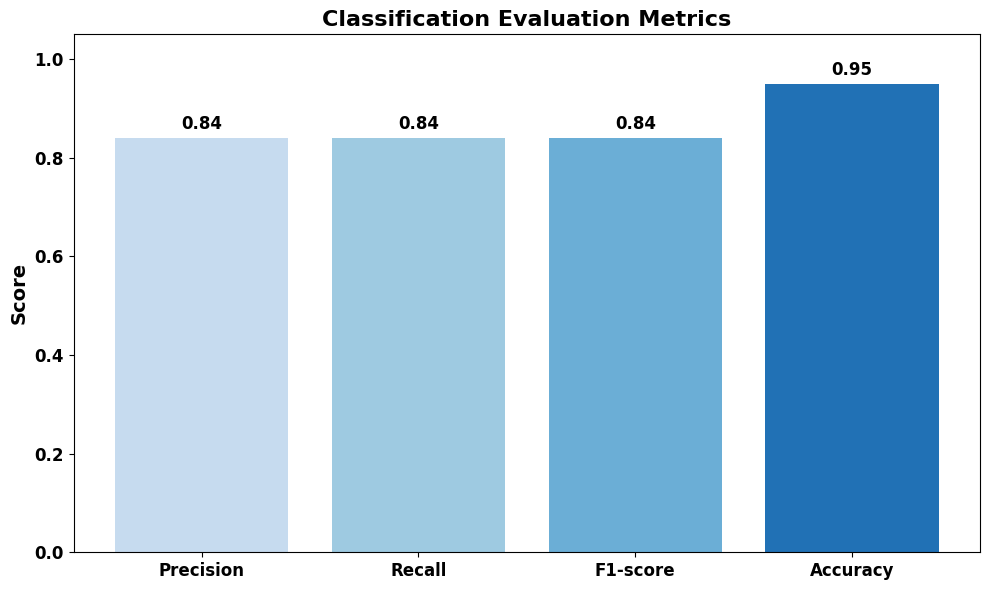

In [1]:
# Re-import necessary libraries after code execution state reset
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']
scores = [0.84, 0.84, 0.84, 0.95]
colors = ['#c6dbef', '#9ecae1', '#6baed6', '#2171b5']

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=colors)

# Make text bold
plt.title('Classification Evaluation Metrics', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels with bold font
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{score:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()
